# (20) ood — ImageNet32

**Motivation**: host = ```any```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

## CIFAR10 trainers

In [3]:
models2load = {
    'iter-pois': dict(
        model_name='poisson_CIFAR10_t-64_z-[2000]_<jacob|mlp>',
        fit_name='b80-ep200-lr(0.0001)_beta(24:0x0.1)_temp(0.05:lin-0.5)_gr(1000)_(2024_09_20,23:36)',
    ),
    'iter-gaus': dict(
        model_name='',
        fit_name='',
    ),
    'amort-pois': dict(
        model_name='poisson_CIFAR10_t-1_z-[2000]_<mlp|mlp>',
        fit_name='b80-ep200-lr(0.0001)_beta(1:0x0.1)_temp(0.05:lin-0.5)_gr(2000)_(2024_09_20,19:15)',
    ),
    'amort-gaus': dict(
        model_name='gaussian_CIFAR10_t-1_z-[2000]_<mlp|mlp>',
        fit_name='b80-ep200-lr(0.0001)_beta(1:0x0.1)_gr(2000)_(2024_09_20,19:46)',
    ),
}
kws = dict(
    # path='Dropbox/chkpts/model_hub/chewie',
    device=device,
    shuffle=False,
    strict=True,
)
models2load = {
    k: {**d, **kws} for
    k, d in models2load.items()
    if len(d['model_name']) > 0 and k == 'iter-pois'  # TODO: remove
}

In [4]:
trainers = {
    name: load_model(**kwargs)[0] for
    name, kwargs in models2load.items()
}

tr = trainers['iter-pois']
tr.model.cfg.clamp_u, tr.model.cfg.clamp_du

(6.5, 6.0)

In [5]:
tr.model.cfg.seq_len, tr.cfg.kl_beta

(64, 24.0)

### Sanity check

In [6]:
print(tr.model.layer.n_exp)

tensor([27, 32, 37, 43, 48, 52, 56, 58, 60, 61, 62, 62, 63, 63, 63, 63, 63, 63,
        63, 63, 63, 63, 64, 63, 64, 64, 64, 63, 63, 63, 63, 63, 63, 63, 63, 63,
        63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63,
        63, 63, 63, 63, 62, 62, 62, 62, 62, 62], device='cuda:0',
       dtype=torch.int32)

100%|█████████████████████████████████| 30/30 [35:39<00:00, 71.30s/it]


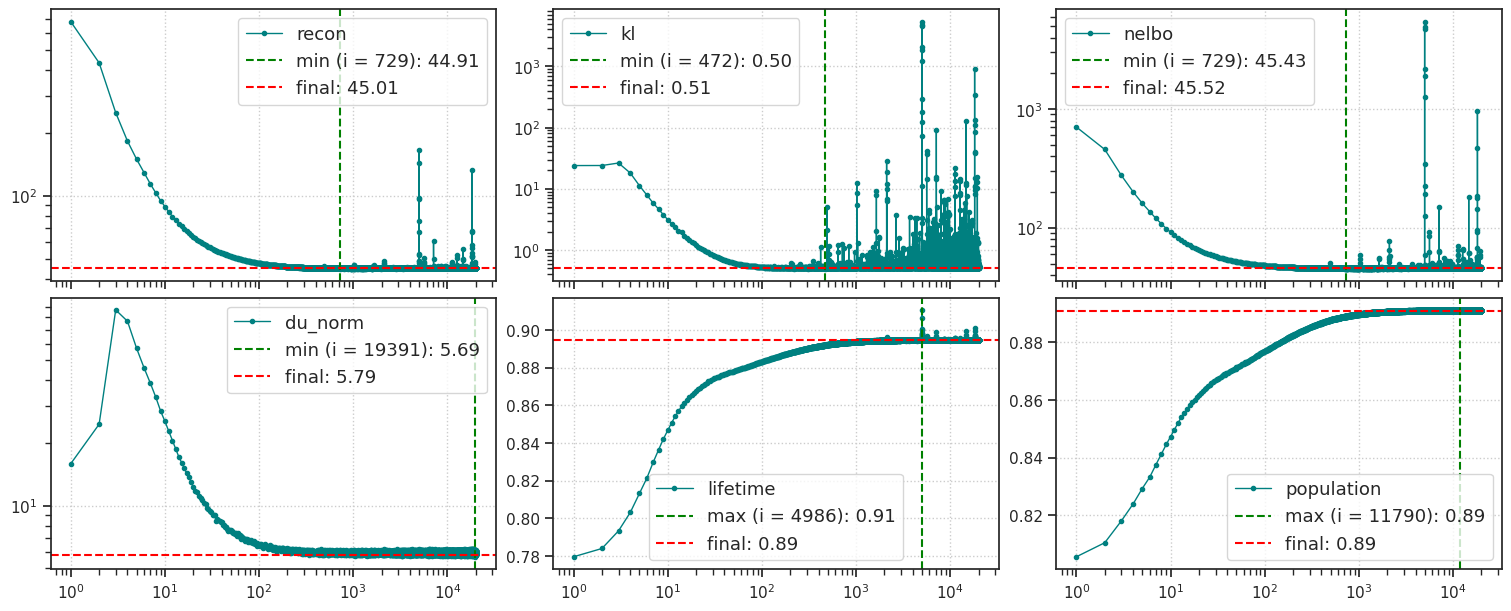

In [7]:
results = tr.analysis('vld', seq_total=20000, n_data_batches=30)
_ = plot_convergence(results, color='teal')

In [6]:
x = next(iter(tr.dl_vld))[0]

In [66]:
translate_x = 0
translate_y = 0

x_translated = F_vis.affine(
    inpt=x,
    angle=0.0,
    scale=1.0,
    shear=[10.0],
    translate=[translate_x, translate_y],
    interpolation=F_vis.InterpolationMode.BILINEAR,
)

In [67]:
num = 32

x2p = torch.cat([x[:num], x_translated[:num]])
x2p = (x2p + 1) / 2
x2p = torch.clip(x2p, 0, 1)
x2p = tonp(x2p)

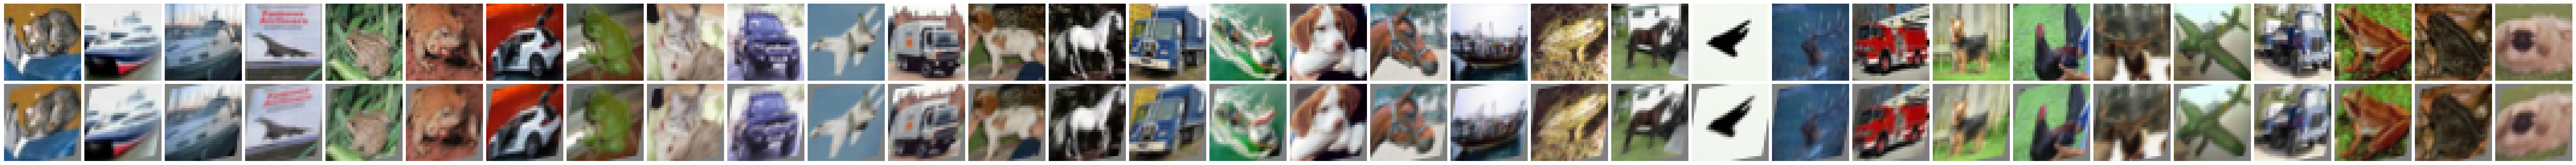

In [68]:
fig, axes = create_figure(2, num, (num * 2, 4))
for i in range(num):
    axes[0, i].imshow(x2p[i].transpose(1, 2, 0))
    axes[1, i].imshow(x2p[i + num].transpose(1, 2, 0))
remove_ticks(axes)
plt.show()

## recon: CIFAR10

In [12]:
kws = dict(
    seq_total=1000,
    seq_batch_sz=100,
    n_data_batches=1,
    # active=~dead,
    return_recon=True,
    full_data=True,
    verbose=False,
)
results_to_plot = {
    name: tr.analysis(dl=name, **kws)
    for name in ['trn', 'vld']
}

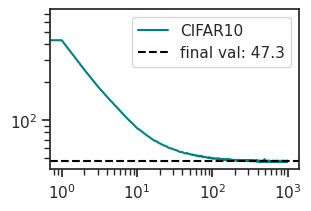

In [13]:
fig, ax = create_figure()
ax.loglog(results_to_plot['vld']['recon'], color='teal', label='CIFAR10')

mse_final = results_to_plot['vld']['recon'][-1]
ax.axhline(mse_final, color='k', ls='--', label=f"final val: {mse_final:0.1f}")

add_legend(ax)
plt.show()

In [14]:
num = 32

x2p_dict = {}
for name, d in results_to_plot.items():
    x2p = np.concatenate([
        d['x'][:num],
        d['y'][:num, -1].reshape(-1, *tr.model.cfg.input_sz),
    ])
    x2p = (x2p + 1) / 2
    x2p = np.clip(x2p, 0, 1)
    x2p_dict[name] = x2p

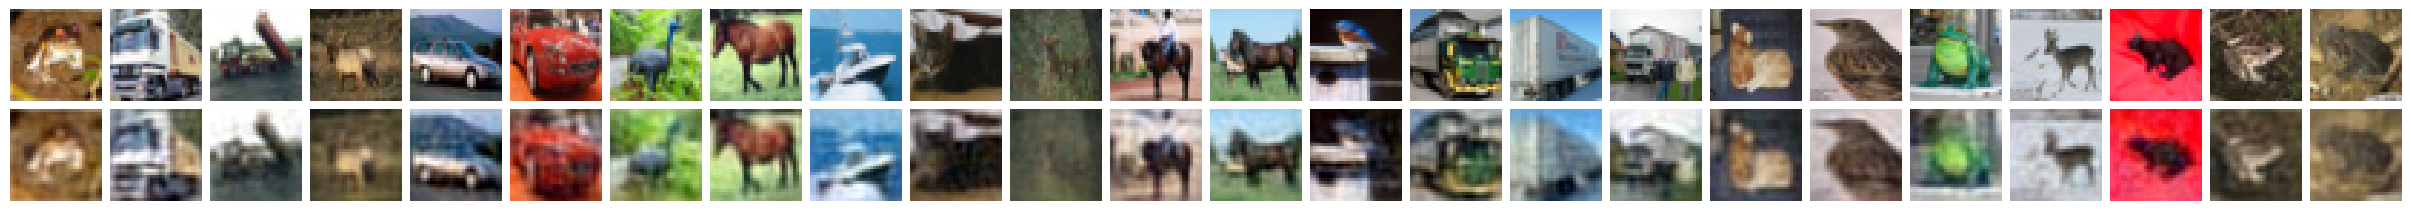

In [15]:
name = 'trn'

fig, axes = create_figure(2, 24, (24, 2))
for i in range(24):
    axes[0, i].imshow(x2p_dict[name][i].transpose(1, 2, 0))
    axes[1, i].imshow(x2p_dict[name][i + 32].transpose(1, 2, 0))
remove_ticks(axes)
plt.show()

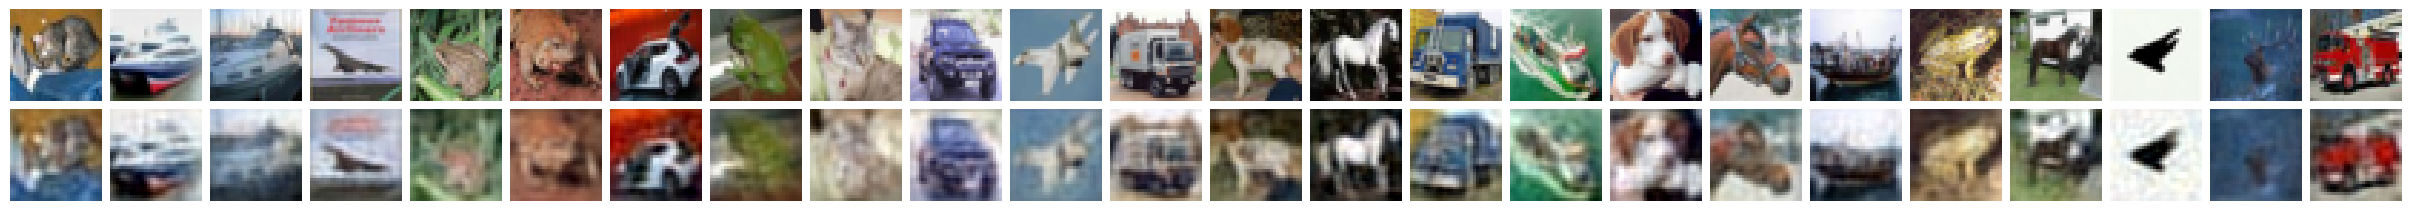

In [16]:
name = 'vld'

fig, axes = create_figure(2, 24, (24, 2))
for i in range(24):
    axes[0, i].imshow(x2p_dict[name][i].transpose(1, 2, 0))
    axes[1, i].imshow(x2p_dict[name][i + 32].transpose(1, 2, 0))
remove_ticks(axes)
plt.show()

## recon: ImageNet32

In [9]:
from base.dataset import make_dataloader

dl_imgnet_vld = make_dataloader('ImageNet32', device, batch_size=64, skip_trn=True)[1]

### iterative

In [14]:
%%time

kws = dict(
    seq_total=10000,
    seq_batch_sz=100,
    n_data_batches=1,
    return_recon=True,
    full_data=True,
    verbose=False,
)
imgnet_iter = trainers['iter-pois'].analysis(
    dl=dl_imgnet_vld, **kws)

CPU times: user 39.6 s, sys: 8.91 s, total: 48.5 s
Wall time: 48.5 s


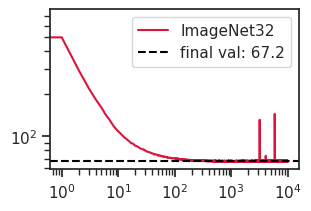

In [15]:
fig, ax = create_figure()
ax.loglog(imgnet_iter['recon'], color='crimson', label='ImageNet32')

mse_final = imgnet_iter['recon'][-1]
ax.axhline(mse_final, color='k', ls='--', label=f"final val: {mse_final:0.1f}")

add_legend(ax)
plt.show()

In [16]:
num = 32

x2p = np.concatenate([
    imgnet_iter['x'][:num],
    imgnet_iter['y'][:num, -1].reshape(tr.model.cfg.shape),
])
x2p = (x2p + 1) / 2
x2p = np.clip(x2p, 0, 1)

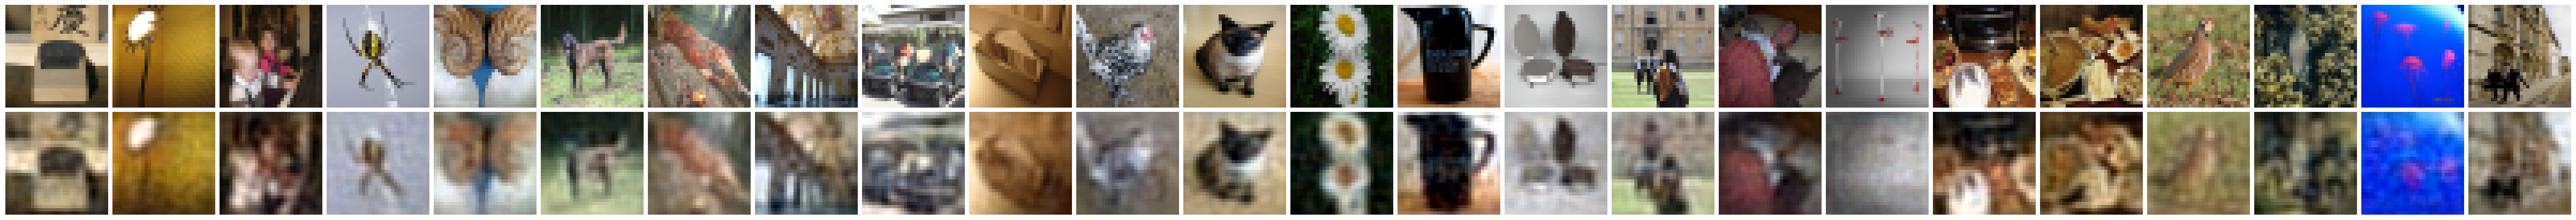

In [17]:
fig, axes = create_figure(2, 24, (48, 4))
for i in range(24):
    axes[0, i].imshow(x2p[i].transpose(1, 2, 0))
    axes[1, i].imshow(x2p[i + 32].transpose(1, 2, 0))
remove_ticks(axes)
plt.show()

### amortized

In [18]:
kws['seq_total'] = 1
imgnet_amort = trainers['amort-pois'].analysis(
    dl=dl_imgnet_vld, **kws)

In [19]:
print(imgnet_amort['recon'][-1])

242.01418

In [20]:
num = 32

x2p = np.concatenate([
    imgnet_amort['x'][:num],
    imgnet_amort['y'][:num, -1].reshape(tr.model.cfg.shape),
])
x2p = (x2p + 1) / 2
x2p = np.clip(x2p, 0, 1)

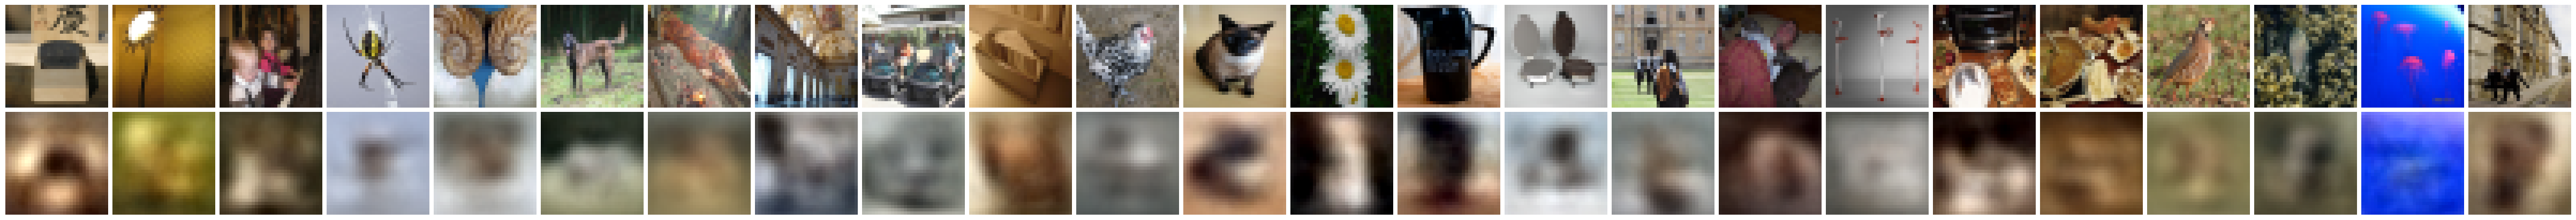

In [21]:
fig, axes = create_figure(2, 24, (48, 4))
for i in range(24):
    axes[0, i].imshow(x2p[i].transpose(1, 2, 0))
    axes[1, i].imshow(x2p[i + 32].transpose(1, 2, 0))
remove_ticks(axes)
plt.show()

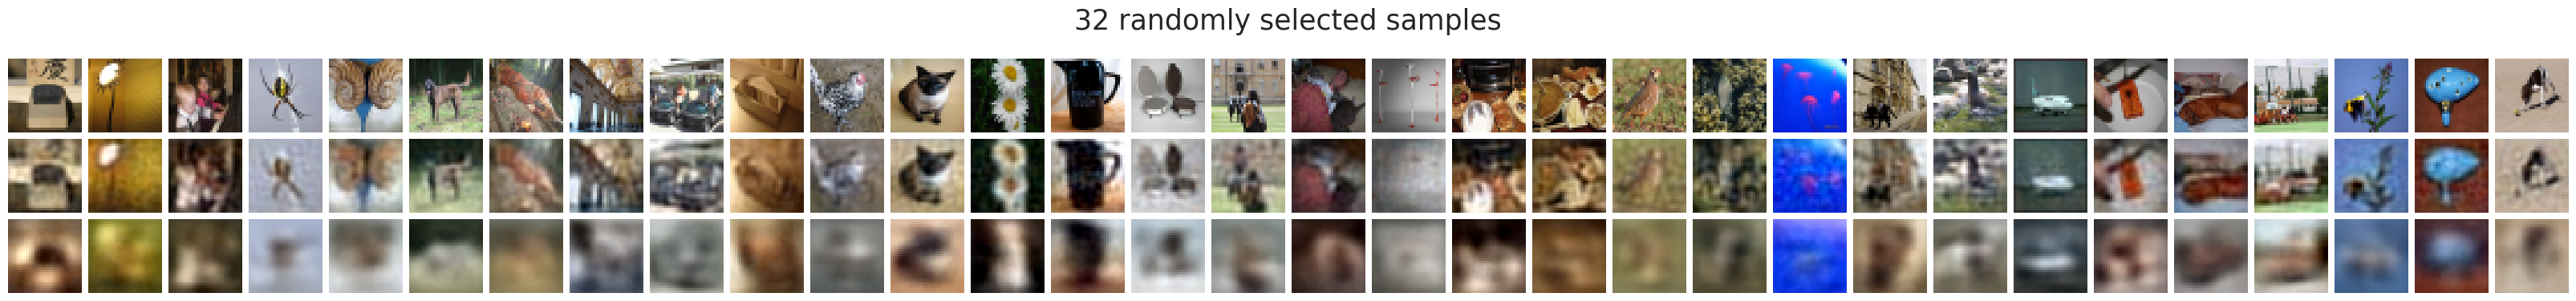

In [59]:
num = 32
inds = range(num)

x2p = [
    imgnet_iter['x'][inds],
    imgnet_iter['y'][inds, -1].reshape(tr.model.cfg.shape),
    imgnet_amort['y'][inds, -1].reshape(tr.model.cfg.shape),
]
nrows = len(x2p)

x2p = np.concatenate(x2p)
x2p = (x2p + 1) / 2
x2p = np.clip(x2p, 0, 1)
x2p = x2p.transpose(0, 2, 3, 1)


fig, axes = create_figure(nrows, num, (num * 1.0, nrows * 1.0))
for i in range(num):
    for j in range(3):
        axes[j, i].imshow(x2p[i + j * num])
remove_ticks(axes)

fig.suptitle(f"{len(inds)} randomly selected samples", fontsize=25, y=1.2)
plt.show()

In [60]:
mse = ((flatten_np(imgnet_iter['x'], start_dim=1) - imgnet_iter['y'][:, -1, :]) ** 2).sum(1)
best_samples = np.argsort(mse)

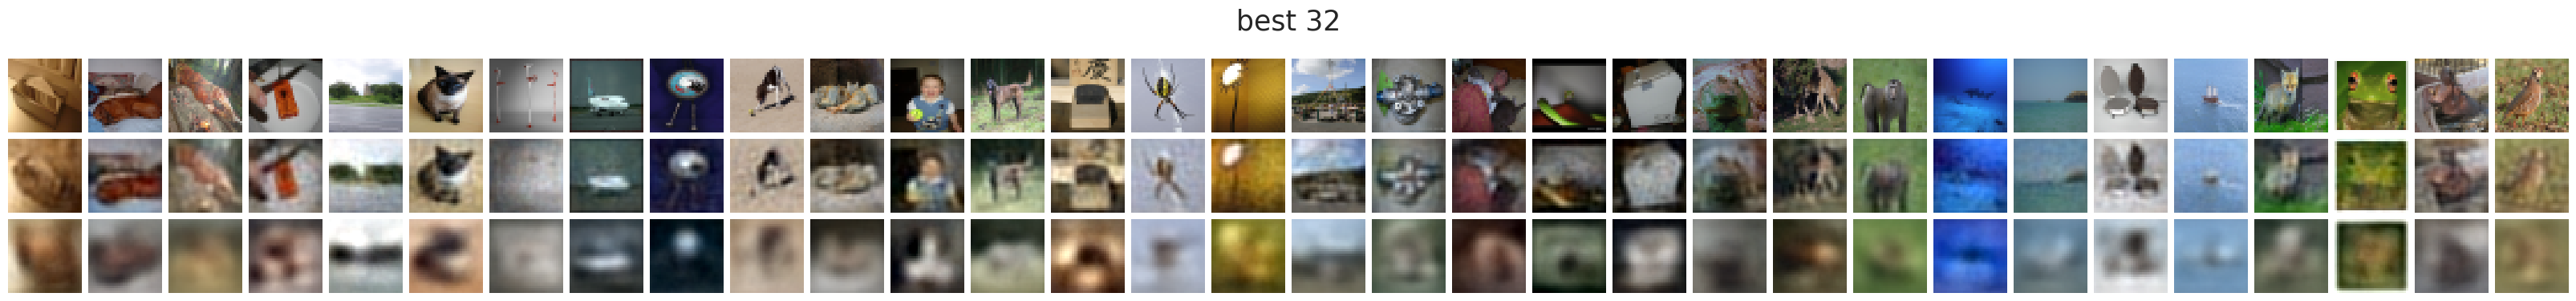

In [61]:
num = 32
inds = best_samples[range(num)]
np.random.shuffle(inds)

x2p = [
    imgnet_iter['x'][inds],
    imgnet_iter['y'][inds, -1].reshape(tr.model.cfg.shape),
    imgnet_amort['y'][inds, -1].reshape(tr.model.cfg.shape),
]
nrows = len(x2p)

x2p = np.concatenate(x2p)
x2p = (x2p + 1) / 2
x2p = np.clip(x2p, 0, 1)
x2p = x2p.transpose(0, 2, 3, 1)


fig, axes = create_figure(nrows, num, (num * 1.0, nrows * 1.0))
for i in range(num):
    for j in range(3):
        axes[j, i].imshow(x2p[i + j * num])
remove_ticks(axes)

fig.suptitle(f"best {len(inds)}", fontsize=25, y=1.2)
plt.show()

In [62]:
mse[inds].mean(), mse[np.delete(range(len(mse)), inds)].mean(), mse.mean()

(39.636703, 94.84645, 67.24158)

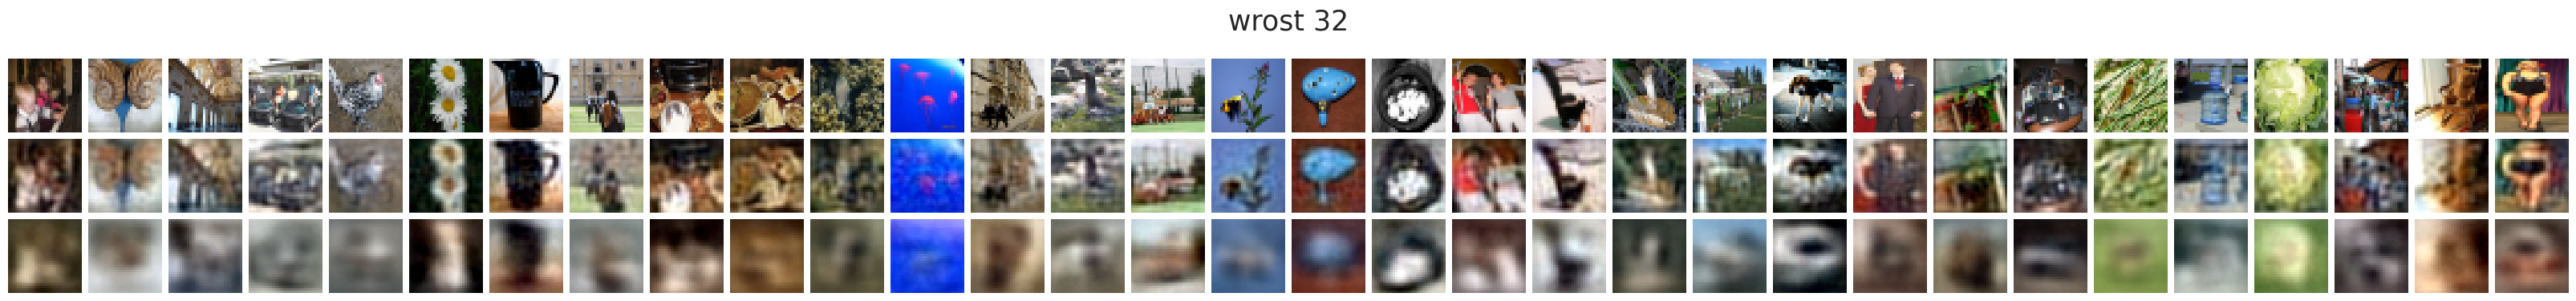

In [63]:
num = 32
inds = np.delete(range(len(mse)), inds)

x2p = [
    imgnet_iter['x'][inds],
    imgnet_iter['y'][inds, -1].reshape(tr.model.cfg.shape),
    imgnet_amort['y'][inds, -1].reshape(tr.model.cfg.shape),
]
nrows = len(x2p)

x2p = np.concatenate(x2p)
x2p = (x2p + 1) / 2
x2p = np.clip(x2p, 0, 1)
x2p = x2p.transpose(0, 2, 3, 1)


fig, axes = create_figure(nrows, num, (num * 1.0, nrows * 1.0))
for i in range(num):
    for j in range(3):
        axes[j, i].imshow(x2p[i + j * num])
remove_ticks(axes)

fig.suptitle(f"wrost {len(inds)}", fontsize=25, y=1.2)
plt.show()

## Generate

In [94]:
tr = trainers['amort-pois']

In [95]:
n_samples = 64
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)
pred = tr.model.pred

shape = (n_samples, *tr.model.cfg.input_sz)
pred = pred.reshape(shape)
pred.shape

torch.Size([64, 3, 32, 32])

In [84]:
n_iters = 120
output = tr.model.generate(pred, seq=range(n_iters))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['loss_kl', 'loss_recon', 'dist', 'ff', 'recon', 'state', 'samples']

In [85]:
shape_y = (n_samples, n_iters, *tr.model.cfg.input_sz)
y = output['recon'].reshape(shape_y)
, y.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 120, 3, 32, 32]))

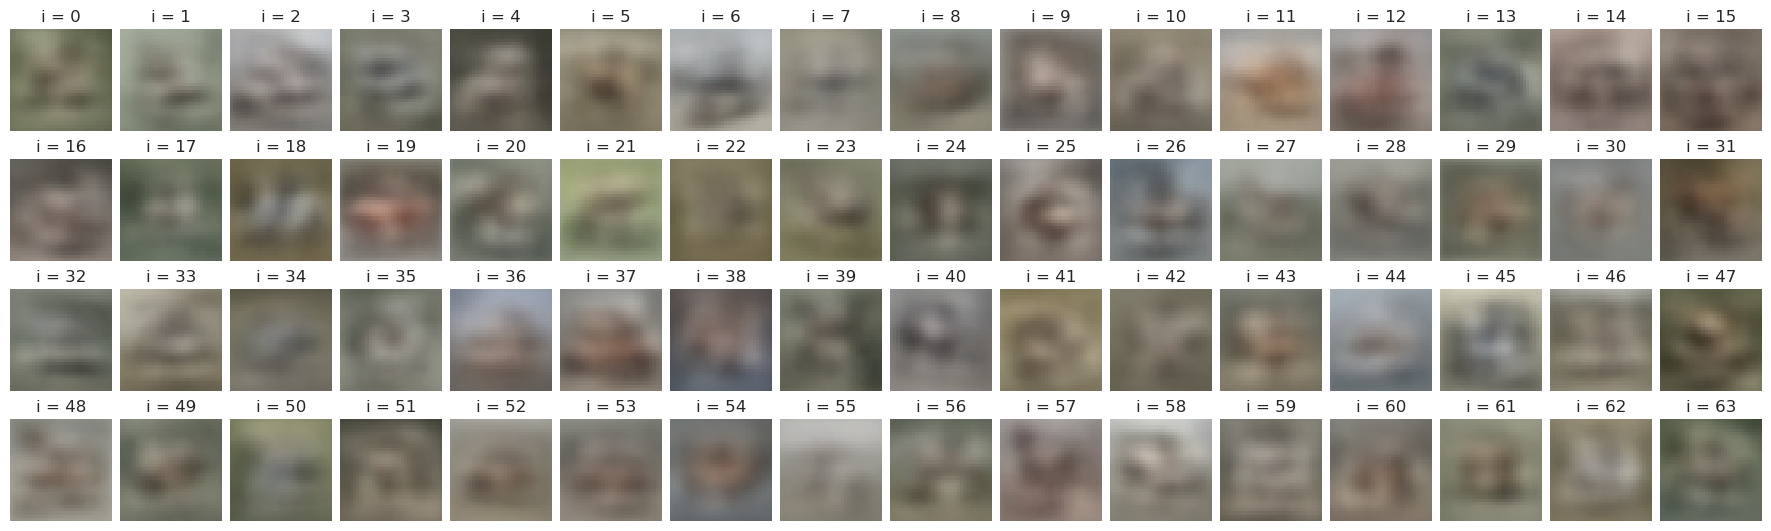

In [96]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')

for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    
    x2p = tonp(pred[sample_i])
    x2p = (1 + x2p) / 2
    x2p = x2p.transpose(1, 2, 0)
    ax.imshow(x2p)
    ax.set_title(f"i = {sample_i}")

trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [87]:
order = np.argsort(desc_len)[::-1]

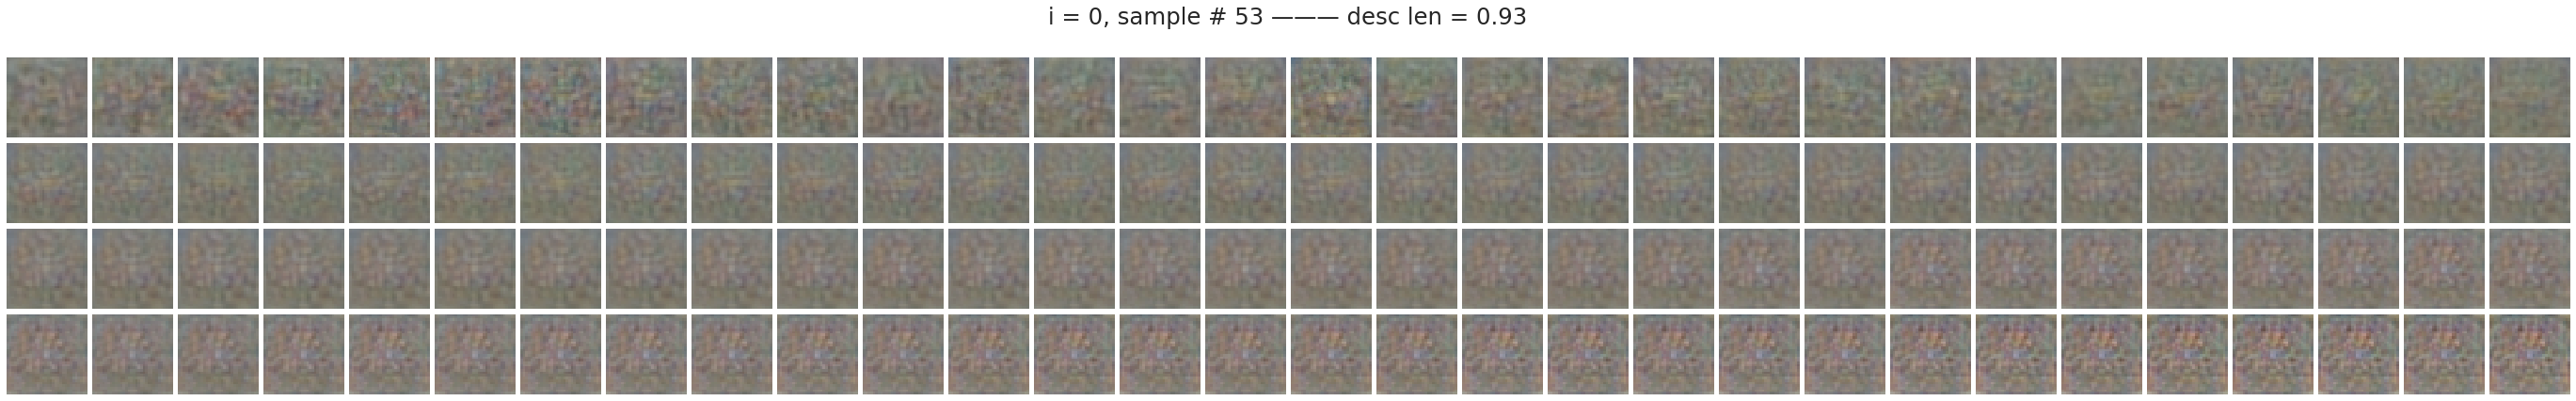

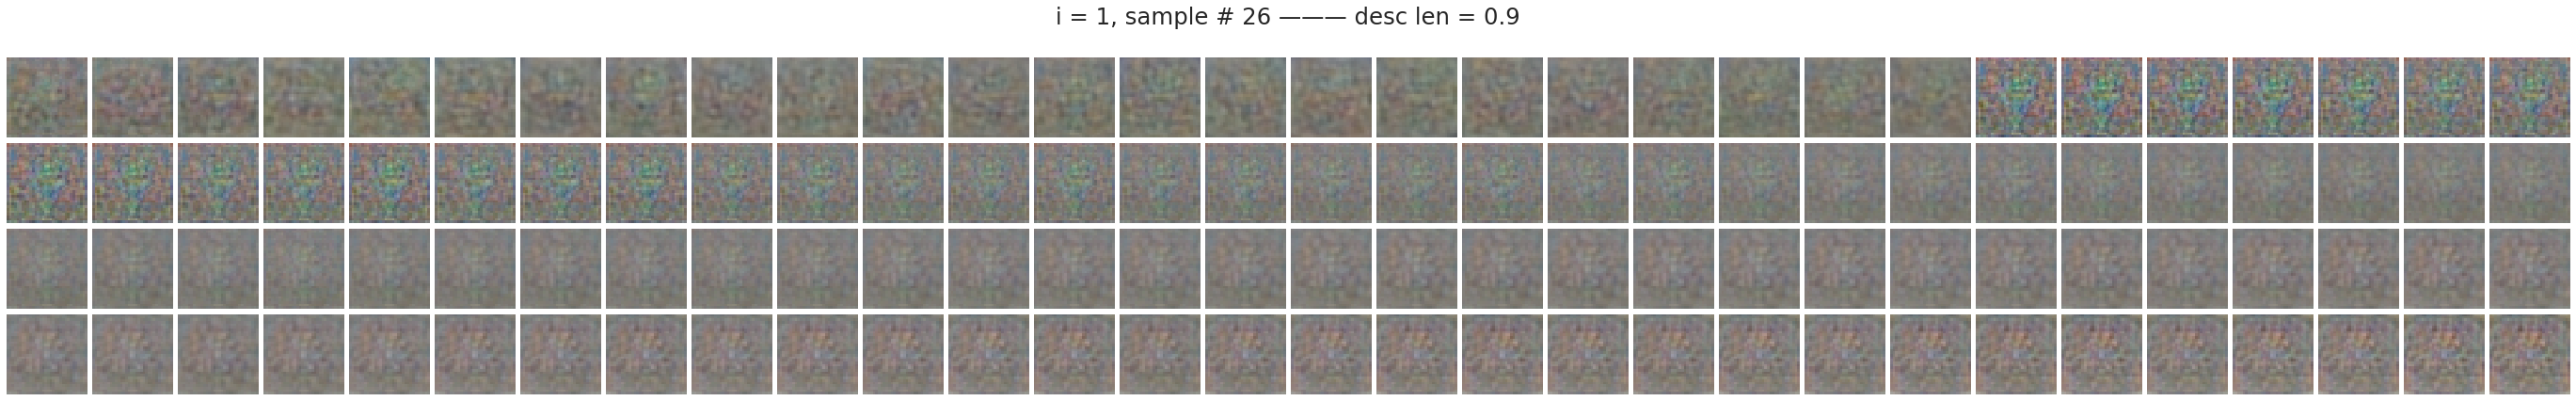

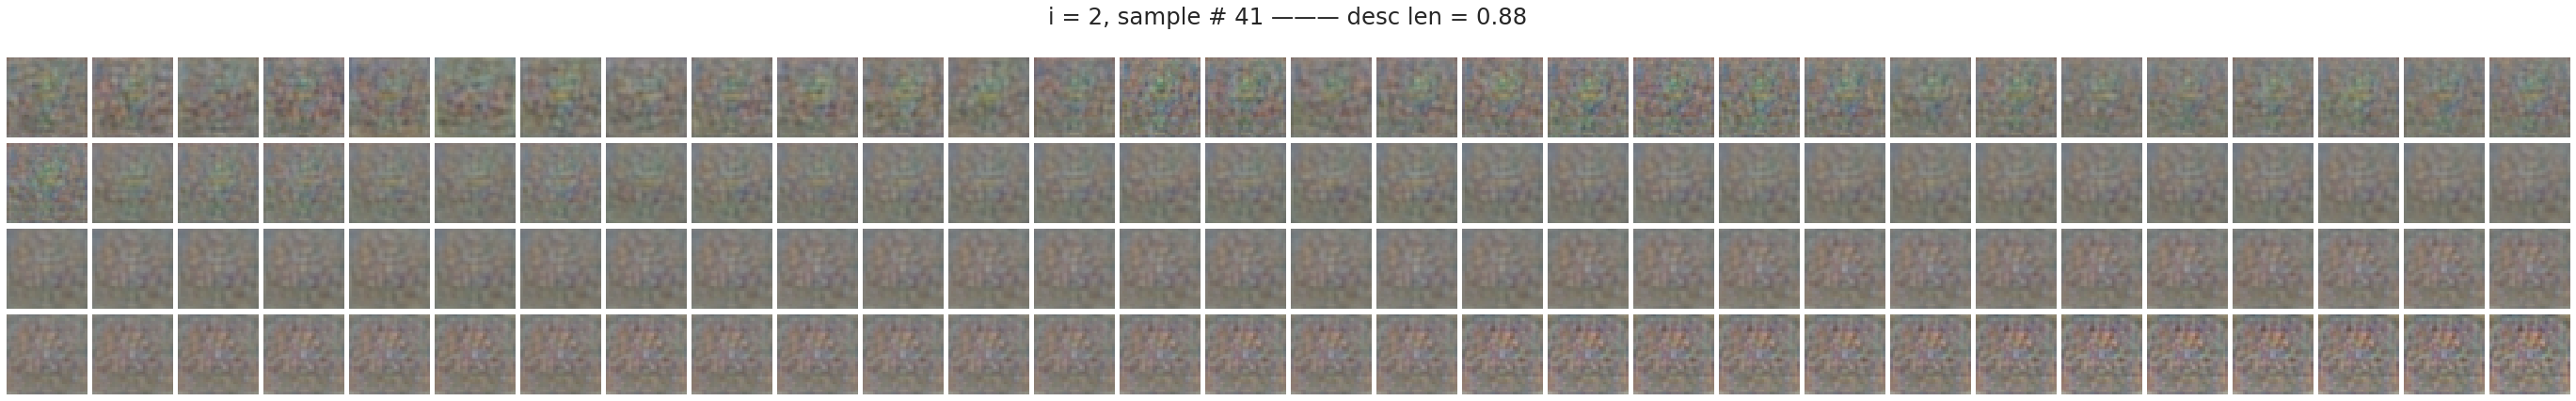

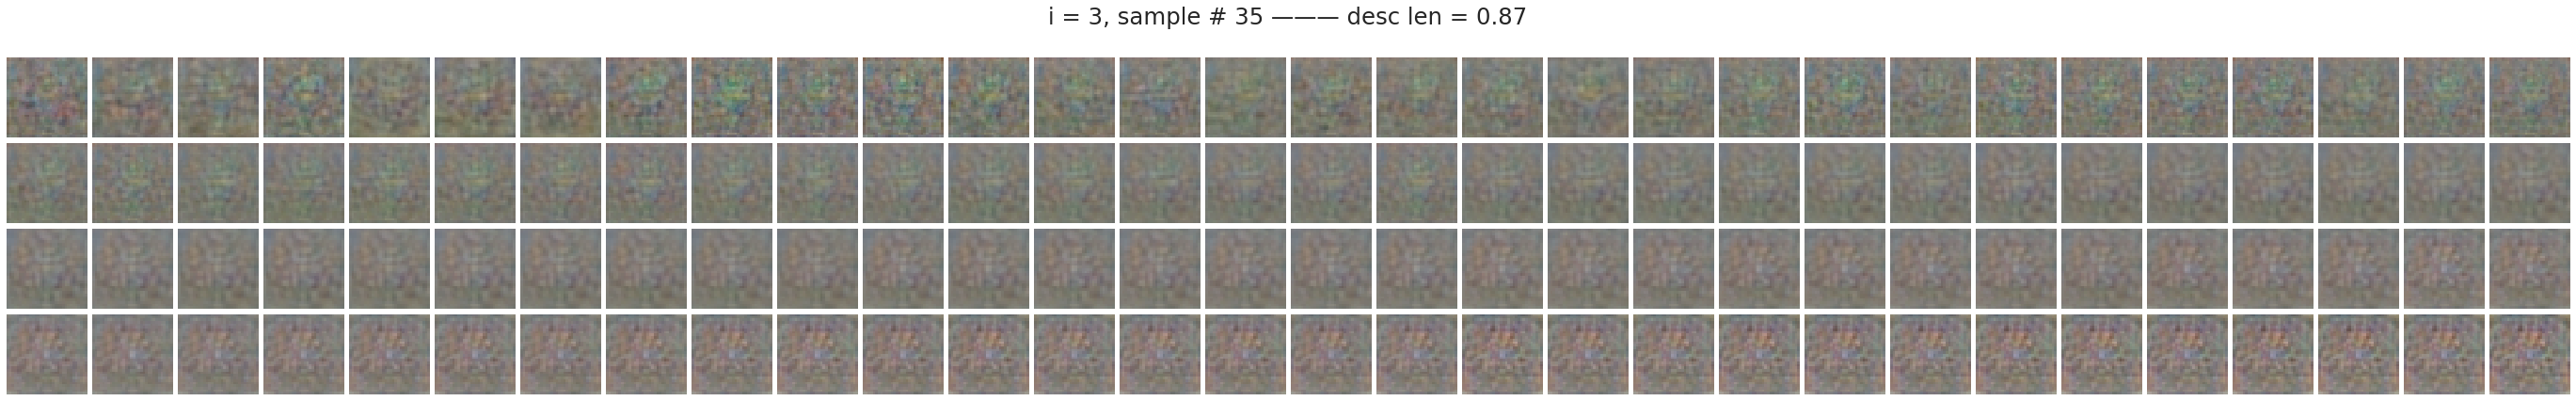

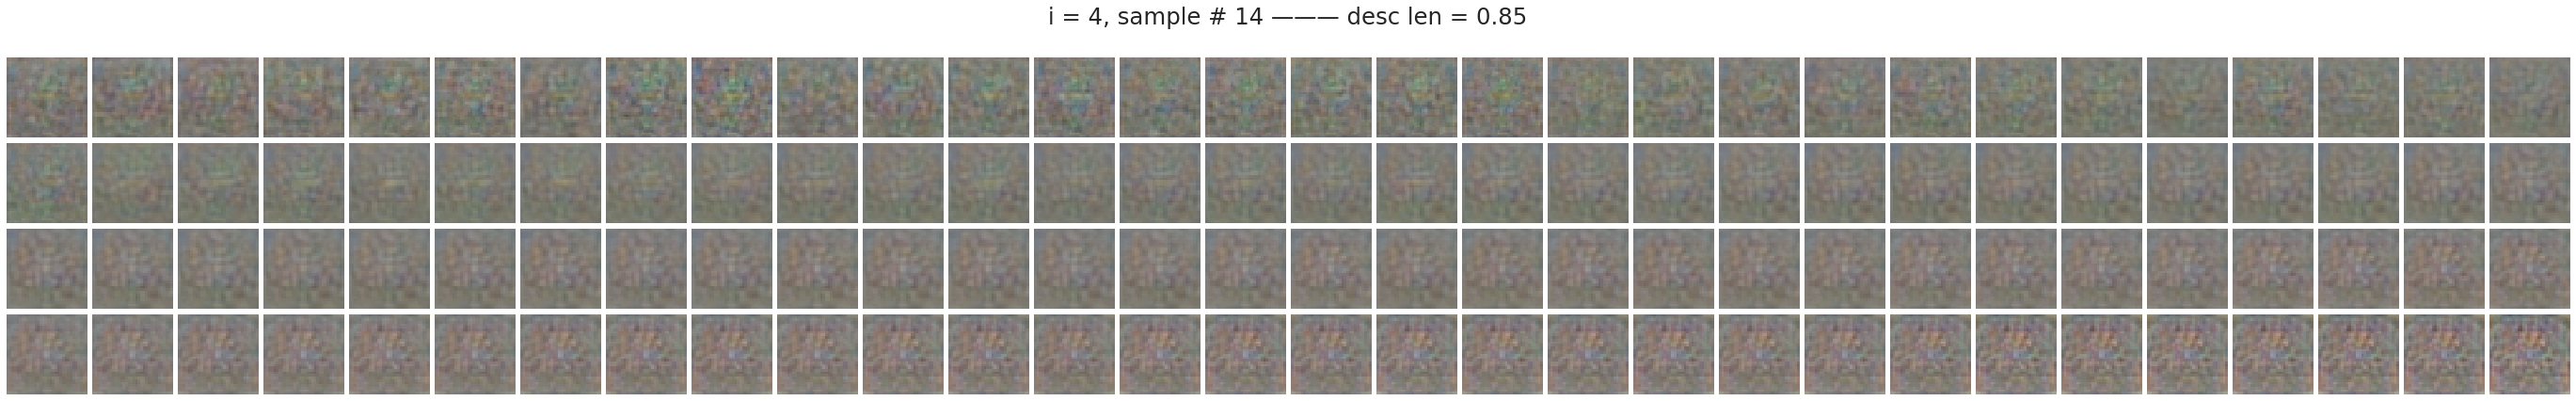

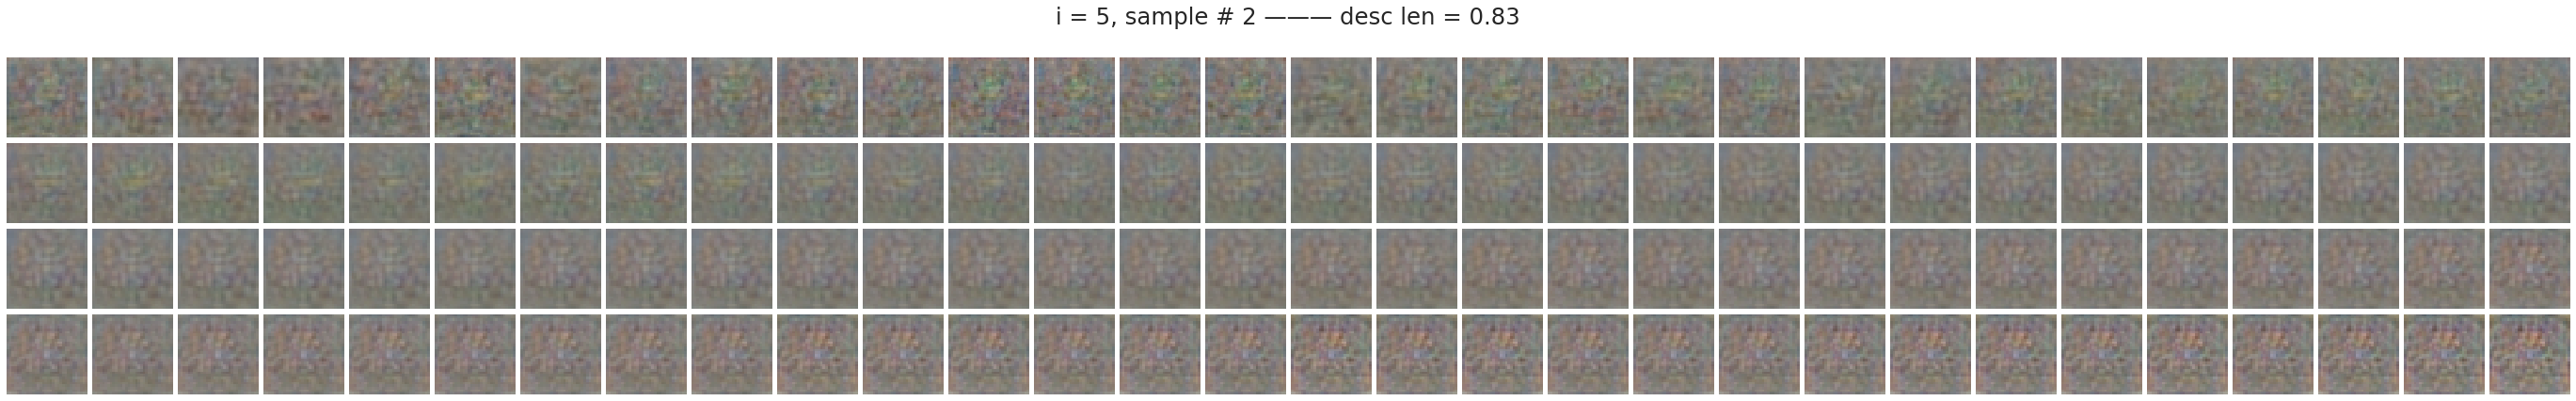

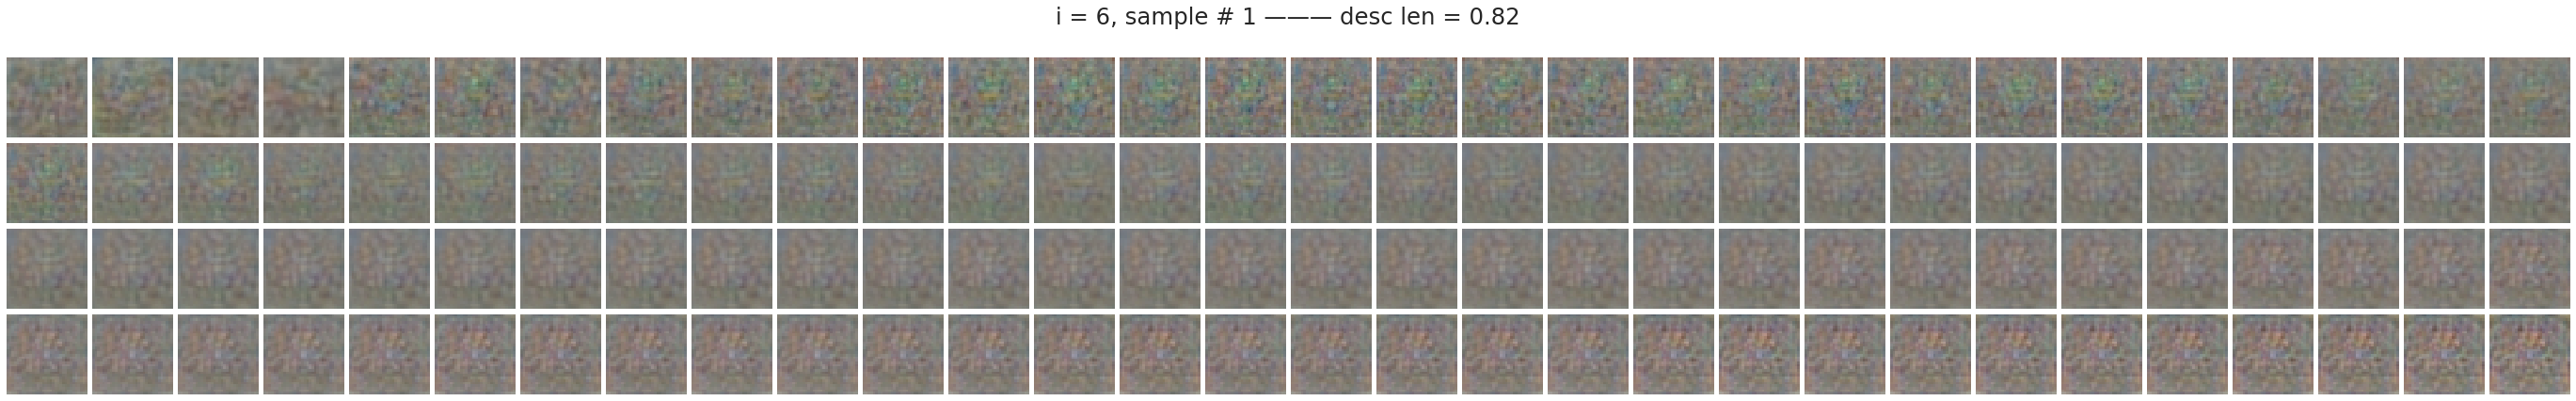

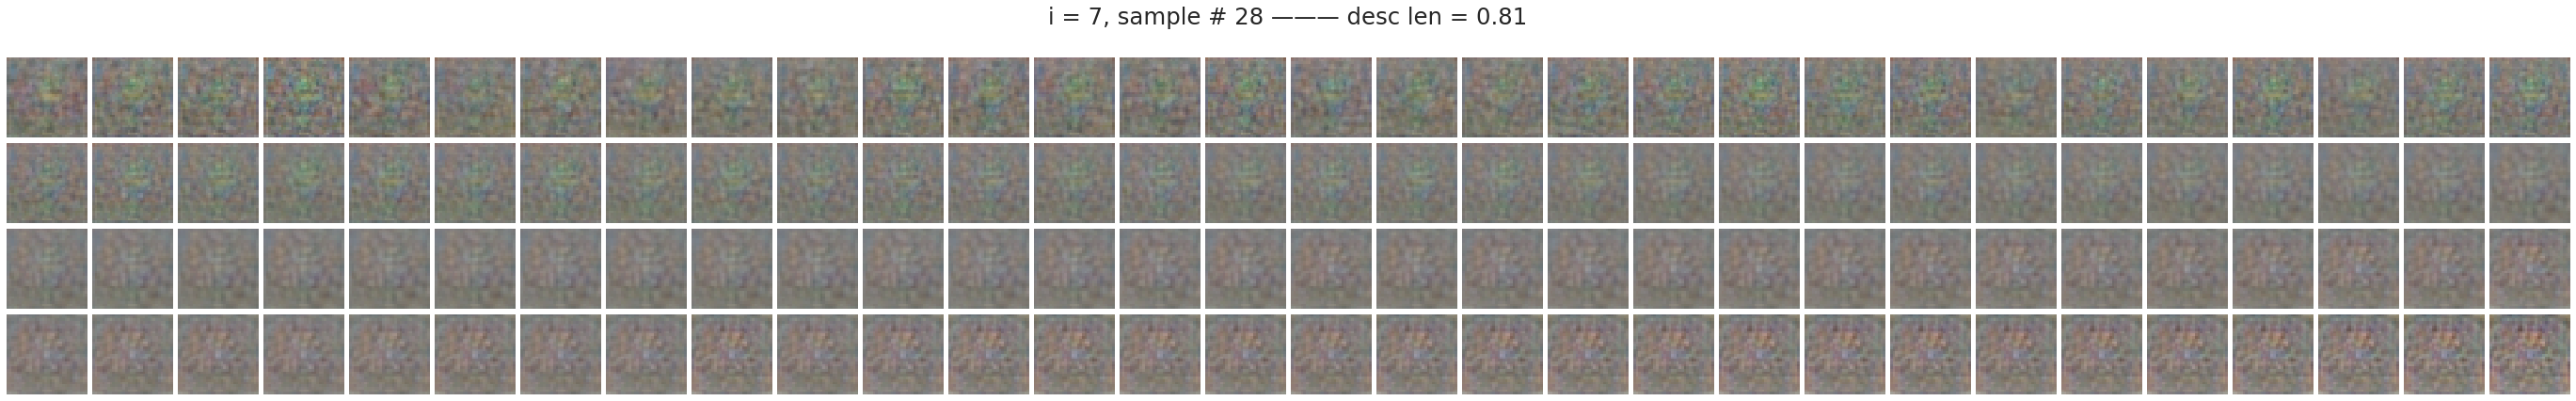

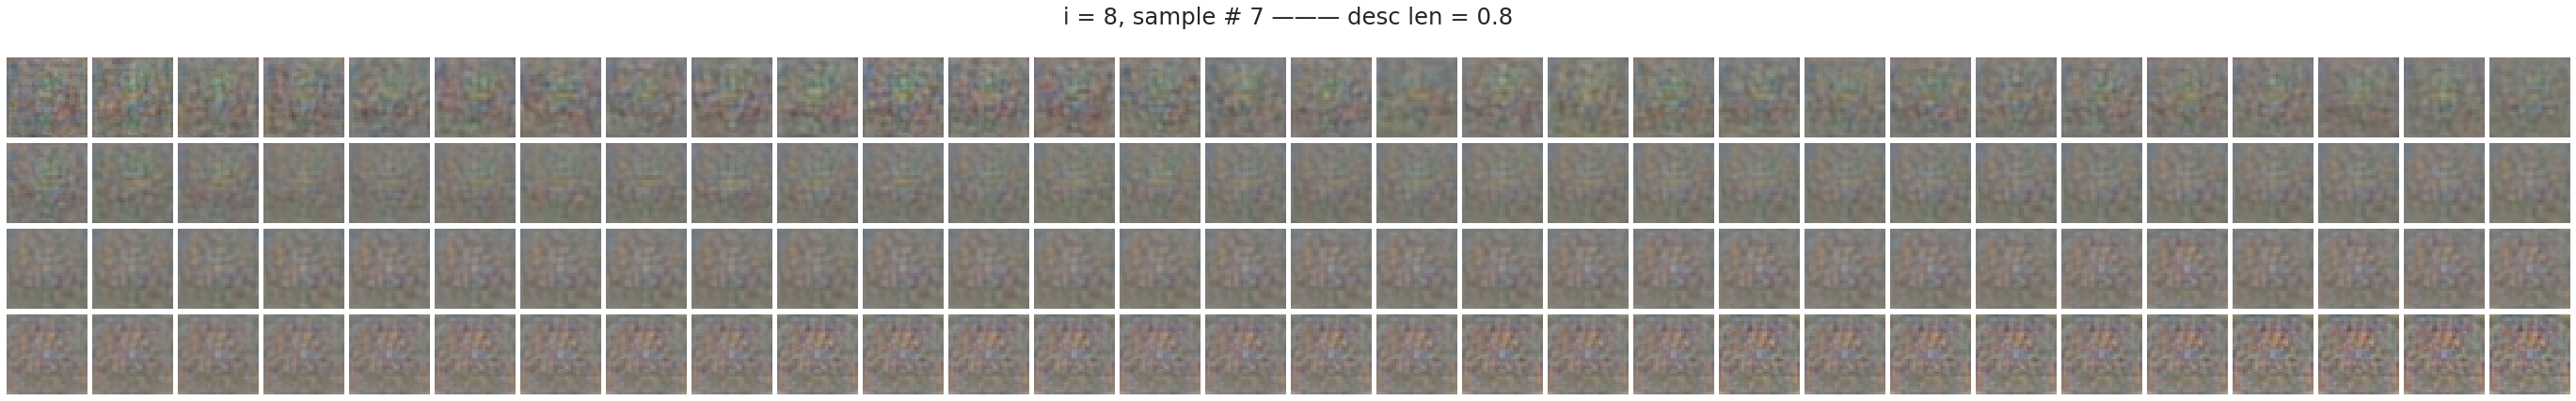

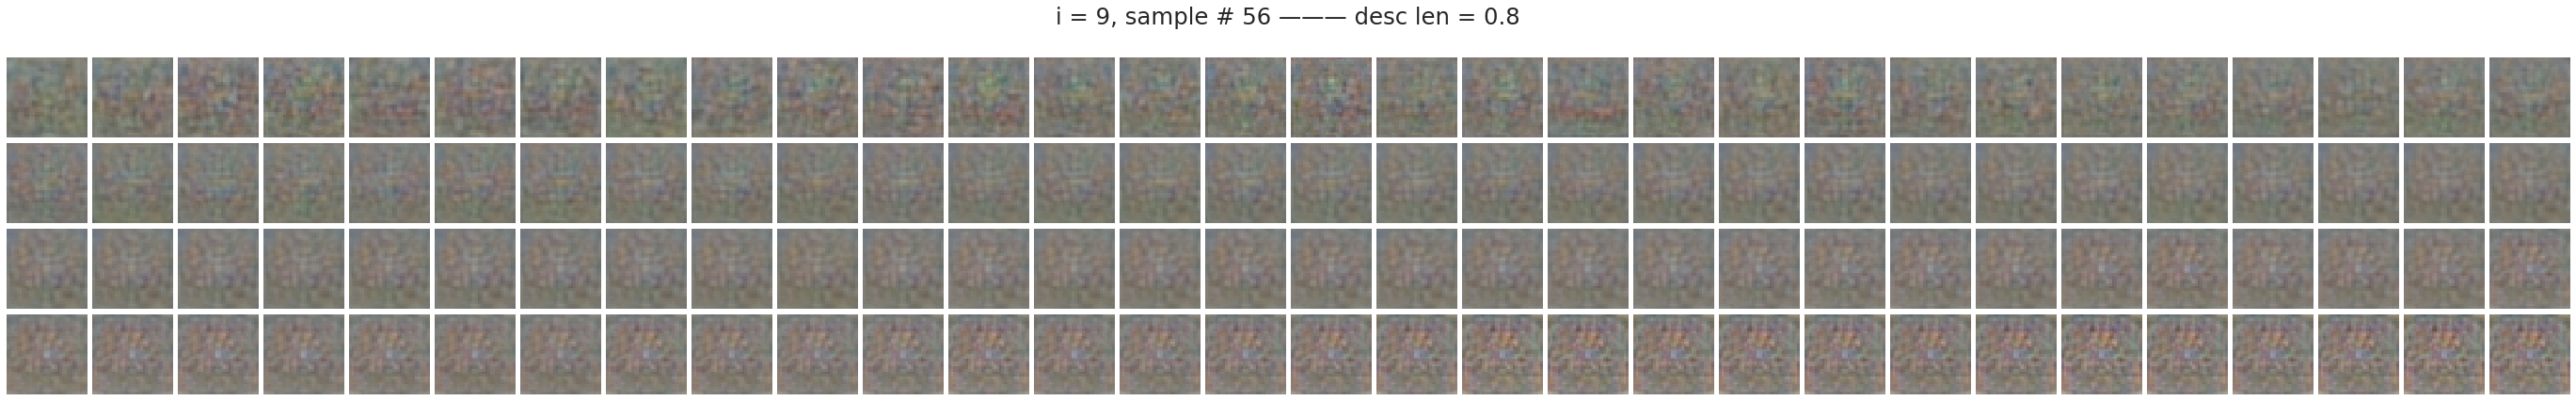

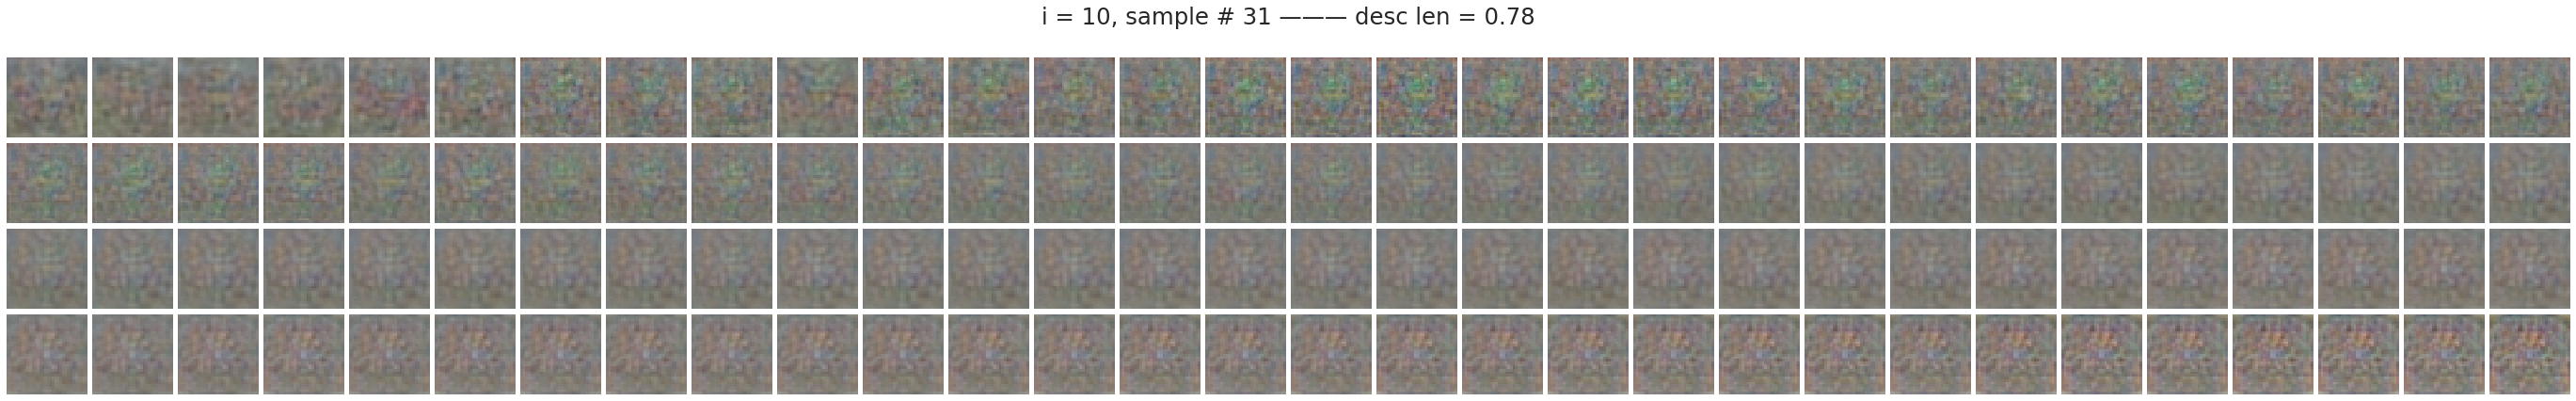

In [88]:
for i in range(len(pred)):
    if i > 10:
        continue
    sample_i = order[i]
    nrows, ncols = 4, 30
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=70)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i])
    x2p = (1 + x2p) / 2
    x2p = x2p.transpose(1, 2, 0)
    axes[0, 0].imshow(x2p)
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        
        x2p = tonp(y[sample_i, idx - 1])
        x2p = (1 + x2p) / 2
        x2p = x2p.transpose(1, 2, 0)
        
        ax.imshow(x2p)

    remove_ticks(axes)
    plt.show()

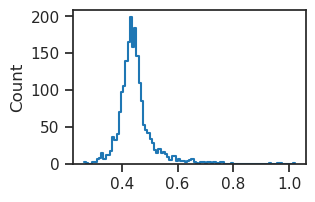

In [69]:
w = tr.model.layer.get_weight()
norms = tonp(torch.linalg.vector_norm(w, dim=1))
histplot(norms);

In [70]:
order = np.argsort(norms)[::-1]
w = tonp(w).reshape(shape)[order]
w.shape

(2048, 3, 32, 32)

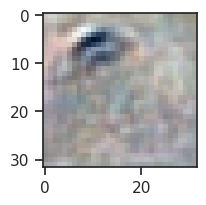

In [101]:
x2p = tonp(w[220])
x2p = x2p.transpose(1, 2, 0)
x2p -= x2p.min()
x2p /= x2p.max()
plt.imshow(x2p)

<Axes: ylabel='Count'>

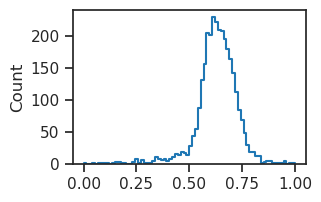

In [102]:
histplot(x2p.ravel())

In [55]:
c = 5
x = torch.randn(100_000) * 3
x_clamped = softclamp_sym(x, c)
x_unclamped = softclamp_sym_inv(x_clamped, c)

<Axes: ylabel='Count'>

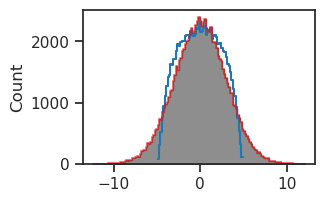

In [56]:
histplot(x, fill=True, color='dimgrey');
histplot(x_clamped, color='C0');
histplot(x_unclamped, color='r', alpha=0.5)

## Quick NLL test

In [6]:
x = next(iter(tr.dl_vld))[0]

In [7]:
nll_batch = tr.model.estimate_nll(
    x=x,
    seq_total=10000,
    n_samples=100,
    with_bce=False,
)

100%|█████████████████████████████████████| 10000/10000 [07:11<00:00, 23.16it/s]


In [8]:
nll = {k: v.mean(0) for k, v in nll_batch.items()}

npix = float(np.prod(tr.model.cfg.input_sz))
nll_perdim = {k: v / npix for k, v in nll.items()}

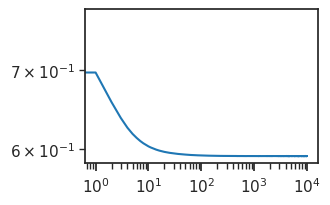

In [9]:
plt.loglog(nll_perdim['mse']);

In [10]:
cumulative_mean(nll_perdim['mse'])

array([0.77829218, 0.73766613, 0.71106942, ..., 0.59207584, 0.59207581,
       0.59207578])

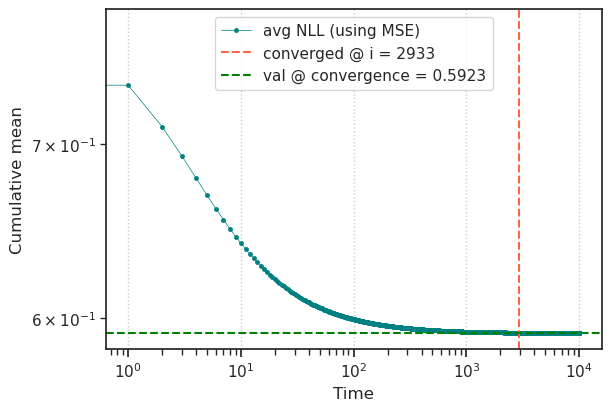

In [12]:
fig, ax = create_figure(1, 1, (6, 4))

cum_mean = cumulative_mean(nll_perdim['mse'])
ax.loglog(
    cum_mean,
    lw=0.5,
    marker='.',
    markersize=5,
    color='teal',
    label='avg NLL (using MSE)',
)

convergence_i = find_cumulative_convergence(
    arr=nll_perdim['mse'], window_size=100, tol=1e-7)
ax.axvline(convergence_i, color='tomato', ls='--', label=f"converged @ i = {convergence_i}")
ax.axhline(cum_mean[convergence_i], color='g', ls='--', label=f"val @ convergence = {cum_mean[convergence_i]:0.4f}")
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Cumulative mean', fontsize=12)

add_legend(ax)
add_grid(ax)
plt.show()

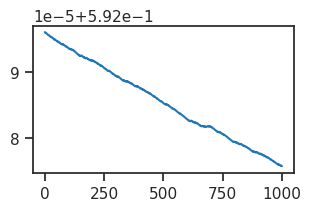

In [13]:
fig, ax = create_figure(1, 1)
ax.plot(cumulative_mean(nll_perdim['mse'])[-1000:]);

In [14]:
np.log(np.pi) / 2, np.log(np.pi * (255 / 2) ** 2) / 2

(0.5723649429247001, 5.420481307523181)

In [55]:
c = 5
x = torch.randn(100_000) * 3
x_clamped = softclamp_sym(x, c)
x_unclamped = softclamp_sym_inv(x_clamped, c)

<Axes: ylabel='Count'>

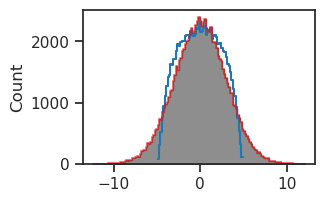

In [56]:
histplot(x, fill=True, color='dimgrey');
histplot(x_clamped, color='C0');
histplot(x_unclamped, color='r', alpha=0.5)